# 데이터 불러오기

In [1]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

# 경고 무시
warnings.filterwarnings('ignore')

#한글 처리를 위해 폰트 설정
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [2]:
df = pd.read_csv('../csv/preprocess.csv')
df.head()

,fraud_bool,income,name_email_similarity,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_24h,date_of_birth_distinct_emails_4w,...,housing_status_BE,housing_status_BF,housing_status_BG,source_INTERNET,source_TELEAPP,device_os_linux,device_os_macintosh,device_os_other,device_os_windows,device_os_x11
0,0,0.9,0.642713,0.0,20,0.009624,105.898067,1724,7394.902554,8,...,1,0,0,1,0,0,0,1,0,0
1,0,0.9,0.720064,200.0,40,0.007018,33.006203,1986,5416.601990,5,...,1,0,0,1,0,0,0,0,1,0
2,0,0.9,0.075432,129.0,40,0.009764,-0.632448,2411,7423.819019,7,...,0,0,0,1,0,0,0,0,1,0
3,0,0.5,0.784344,240.0,20,0.017281,-1.612753,1731,4489.610329,8,...,1,0,0,1,0,1,0,0,0,0
4,0,0.8,0.770435,150.0,40,9.370346,26.733867,1863,6301.097061,7,...,0,0,0,1,0,1,0,0,0,0


# 분석

In [3]:
train_cols = df.columns[1:]
X = df[train_cols] # 독립변수
y = df["fraud_bool"] # 종속변수
df["fraud_bool"].value_counts()

0    6871
1    6871
Name: fraud_bool, dtype: int64

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 0)

In [ ]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(random_state=0)),
    ])
params = {
    # 'clf__max_depth': list(range(3,6)),
    # 'clf__n_estimators': list(range(10,110,10)),
    'clf__max_leaf_nodes': list(range(3, 300, 5)),
    'clf__min_samples_split': list(range(2, 403, 10)),
    }
grid = GridSearchCV(pipe, params, scoring='accuracy', cv=3)
grid.fit(X, y)
print(grid.best_params_)
print(grid.best_score_)

# {'clf__max_depth': 4, 'clf__n_estimators': 40}
# 0.7524390185777786

# 시각화

In [ ]:
model = grid.best_estimator_['clf']
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, n_estimators=40, random_state=0)

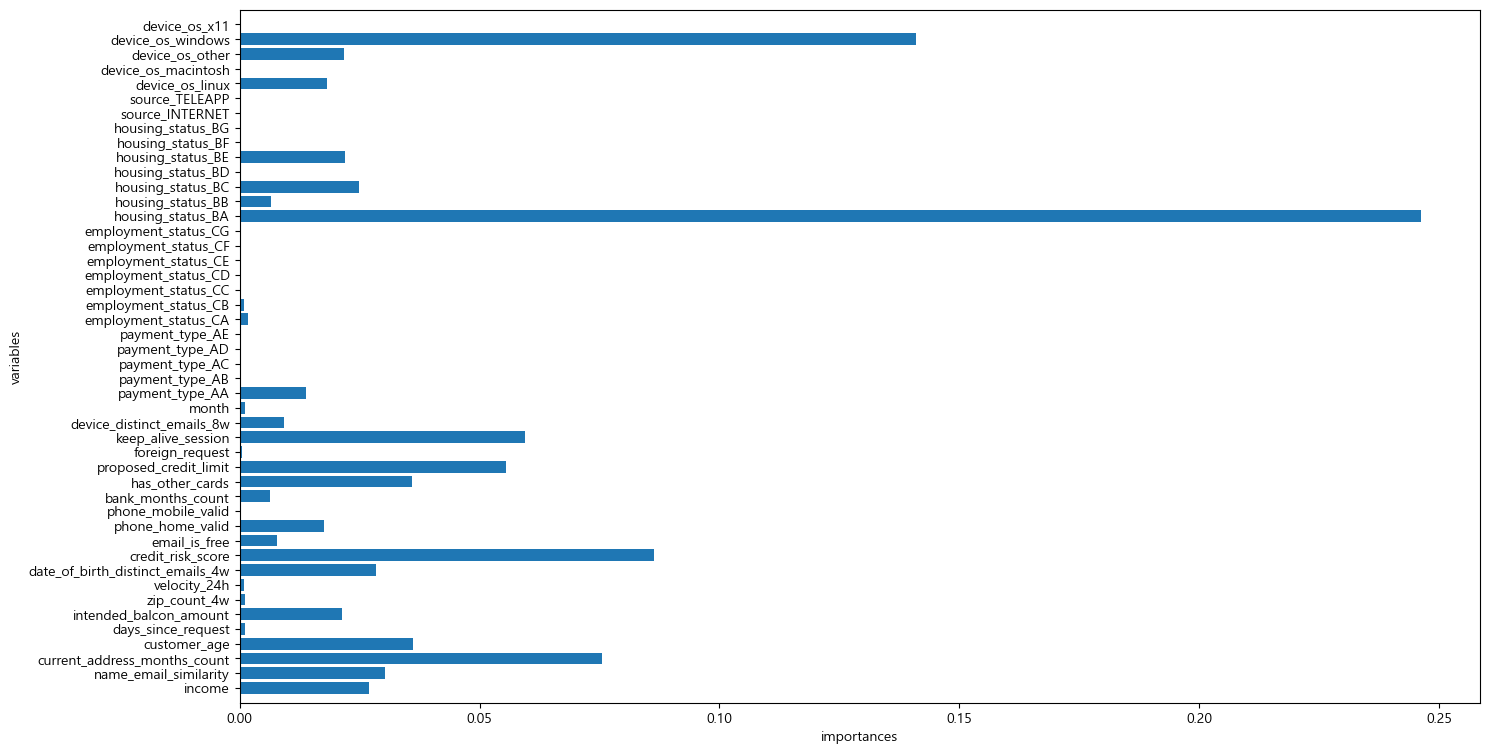

In [ ]:
import numpy as np
def plot_tree(model):
    n_features = X.shape[1]
    plt.rcParams['figure.figsize'] = (16, 9)
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), train_cols)
    plt.xlabel("importances")
    plt.ylabel("variables")
    plt.ylim(-1, n_features)
plot_tree(model)

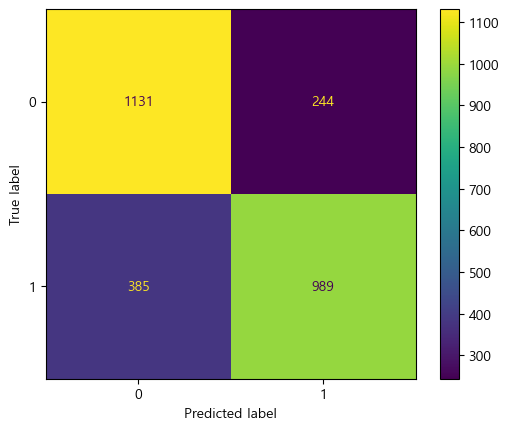

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, model.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.75      0.82      0.78      1375
           1       0.80      0.72      0.76      1374

    accuracy                           0.77      2749
   macro avg       0.77      0.77      0.77      2749
weighted avg       0.77      0.77      0.77      2749



# 저장

In [ ]:
result = pd.read_csv('../csv/model_results.csv')
result.head()

,Model,Best Score,Best Parameter
0,KNN,0.768374,"{'clf__n_neighbors': 20, 'clf__p': 2, 'clf__we..."
1,ANN,0.745668,"{'clf__activation': 'relu', 'clf__alpha': 0.1,..."
2,DNN,0.784820,"{'clf__batch_size': 128, 'clf__epochs': 50, 'c..."
3,Tree,0.692843,{'clf__max_depth': 4}
4,Logit,0.788022,{'clf__C': 0.1}


In [ ]:
if 'RF' in result.Model.values.tolist():
    result.loc[result.Model.values.tolist().index('RF')] = ['RF', grid.best_score_, grid.best_params_]
else:
    result.loc[len(result.index)] = ['RF', grid.best_score_, grid.best_params_]
result.head()

,Model,Best Score,Best Parameter
0,KNN,0.768374,"{'clf__n_neighbors': 20, 'clf__p': 2, 'clf__we..."
1,ANN,0.745668,"{'clf__activation': 'relu', 'clf__alpha': 0.1,..."
2,DNN,0.784820,"{'clf__batch_size': 128, 'clf__epochs': 50, 'c..."
3,Tree,0.692843,{'clf__max_depth': 4}
4,Logit,0.788022,{'clf__C': 0.1}


In [ ]:
result.to_csv('../csv/model_results.csv', index=None)